# DEEP LEARNING PIPELINE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install keras tensorflow

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Input, LSTM, Dense, Activation
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing import image
from keras.layers import Reshape
from keras.layers import RepeatVector
from sklearn.model_selection import train_test_split
import numpy as np
import os

In [ ]:
# Define image dimensions and number of channels
img_width = 224
img_height = 224
num_channels = 3

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)  # Assuming you are using a pre-trained model like InceptionV3
    return img_array

# Specify the path to the folder containing EEG signal images
folder_path = "/content/drive/MyDrive/ML_Seizure_Project/DL_Pipeline"

# Get a list of all files in the folder
image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('.jpg', '.png', '.jpeg'))]

# Automatically create labels based on file names
labels = [int(os.path.splitext(file)[0][-1]) for file in image_files]

# Load EEG signal images and preprocess them if needed
eeg_images = []
for path in image_files:
    img = load_and_preprocess_image(path)  # Implement a function to load and preprocess images
    eeg_images.append(img)

# Convert data to NumPy arrays
eeg_images = np.array(eeg_images)
labels = np.array(labels)


# CNN Model for Spatial Feature Extraction
cnn_model = Sequential()
cnn_model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(img_width, img_height, num_channels)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(256, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Flatten())



time_steps = 10  # You may need to adjust this based on your data
cnn_features = cnn_model.output_shape[1]


# LSTM Model for Temporal Feature Extraction
lstm_model = Sequential()
lstm_model.add(LSTM(128, input_shape=(time_steps, cnn_features)))  # Adjust time_steps based on your data
lstm_model.add(Dense(64, activation='relu'))

# Combine CNN and LSTM Models
image_input = Input(shape=(img_width, img_height, num_channels))
encoded_image = cnn_model(image_input)

# Reshape the output to match the LSTM input shape
reshaped_cnn_output = Reshape((time_steps, cnn_features))(RepeatVector(time_steps)(Flatten()(encoded_image)))
temporal_features = lstm_model(reshaped_cnn_output)

# Fully Connected Layer with ReLU Activation
fc_layer = Dense(256, activation='relu')(temporal_features)

# Output Layer with Sigmoid Activation for Binary Classification (Seizure or not)
output_layer = Dense(1, activation='sigmoid')(fc_layer)

x_train, x_val, y_train, y_val = train_test_split(eeg_images, labels, test_size=0.2, random_state=42)

# Build the final model
eeg_model = Model(inputs=image_input, outputs=output_layer)

# Compile the model
eeg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Assuming you have a dataset with image_data and corresponding labels
# x_train: EEG signal images, y_train: labels (0 or 1 for seizure or not)
eeg_model.fit(x_train, y_train, epochs=10, batch_size=len(x_train), validation_split=0.2)

# ... (Rest of the code remains unchanged)

# Fit the model with the loaded data
eeg_model.fit(eeg_images, labels, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
1/1 [==============================] - 19s 19s/step - loss: 0.7989 - accuracy: 0.0833 - val_loss: -3.6254 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 14s 14s/step - loss: -2.6644 - accuracy: 0.0000e+00 - val_loss: -6.9158 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 14s 14s/step - loss: -5.0989 - accuracy: 0.0000e+00 - val_loss: -10.8354 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 15s 15s/step - loss: -7.8343 - accuracy: 0.0000e+00 - val_loss: -13.5018 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 15s 15s/step - loss: -9.8613 - accuracy: 0.0000e+00 - val_loss: -16.0393 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 17s 17s/step - loss: -11.7739 - accuracy: 0.0000e+00 - val_loss: -19.0850 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 17s 17s/step - loss: -13.9467 - accuracy: 0.0000e+00 - v

In [ ]:

example_image_path = "/content/drive/MyDrive/ML_Seizure_Project/DL_Pipeline/vertical_stacking_038.png"
example_image = load_and_preprocess_image(example_image_path)

# Reshape the image to match the input shape expected by your model
example_image = np.expand_dims(example_image, axis=0)  # Add batch dimension

# Make predictions
predictions = eeg_model.predict(example_image)
print(predictions)

# Interpret the results (assuming binary classification)
threshold = 0.5
predicted_class = 1 if predictions[0, 0] > threshold else 0
#print("Threshold:",threshold)


# Print the predicted class
print("Predicted Class:", predicted_class)

1/1 [==============================] - 1s 590ms/step
[[0.9999998]]
Predicted Class: 1


In [ ]:
from keras.models import Model

# Define a model to extract features from the desired layer
feature_extraction_model = Model(inputs=image_input, outputs=fc_layer)

# Extract features from EEG signal images
features = feature_extraction_model.predict(eeg_images)

# Now, you can use the 'features' array as input to t-SNE for visualization


1/1 [==============================] - 4s 4s/step


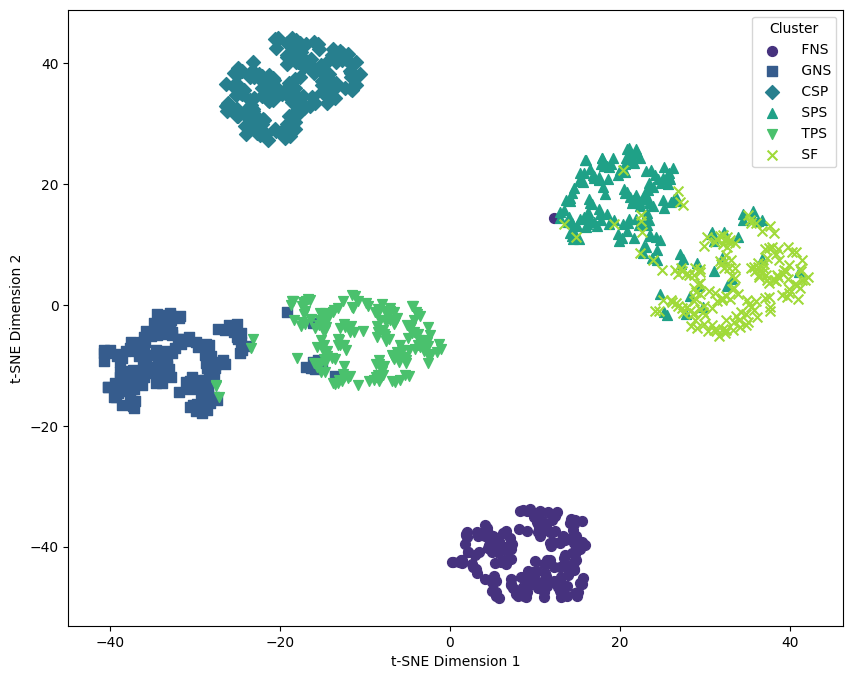

In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs

n_samples = features
n_features = 2
n_clusters = 6

X, y = make_blobs(n_samples=n_samples, centers=n_clusters, n_features=n_features, random_state=42)

data = pd.DataFrame(X, columns=[f'Feature_{i+1}' for i in range(n_features)])
data['Category'] = y

category_column = 'Category'

custom_labels = {0: 'FNS', 1: 'GNS', 2: 'CSP', 3: 'SPS', 4: 'TPS', 5: 'SF'}
custom_symbols = {0: 'o', 1: 's', 2: 'D', 3: '^', 4: 'v', 5: 'x'}

tsne = TSNE(n_components=2, random_state=42)

X_embedded = tsne.fit_transform(X)

embedded_df = pd.DataFrame(X_embedded, columns=['Component 1', 'Component 2'])
embedded_df[category_column] = [custom_labels[cat] for cat in y]

custom_colors = sns.color_palette('viridis', n_colors=n_clusters)

plt.figure(figsize=(10, 8))
for i, (category, color) in enumerate(zip(custom_labels.values(), custom_colors)):
    group = embedded_df[embedded_df[category_column] == category]
    symbol = custom_symbols[i]
    plt.scatter(group['Component 1'], group['Component 2'], label=f' {category}', color=color, marker=symbol, s=50)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Cluster')
plt.show()